In [1]:
using Plots
using Revise
using Statistics
import Distributions
using HypothesisTests
using QuadGK
using Random
using DifferentialEquations
include("src/Trajectories.jl")
using .QuTaM

In [94]:
using Pkg
Pkg.add("Revise")

   Resolving package versions...
   Installed CodeTracking ───── v1.3.6
   Installed LoweredCodeUtils ─ v3.1.0
   Installed JuliaInterpreter ─ v0.9.38
   Installed Revise ─────────── v3.6.4
    Updating `~/Documents/Research/MonitoringMetrology/QuTaM.jl/Project.toml`
  [295af30f] + Revise v3.6.4
    Updating `~/Documents/Research/MonitoringMetrology/QuTaM.jl/Manifest.toml`
 [da1fd8a2] + CodeTracking v1.3.6
  [aa1ae85d] + JuliaInterpreter v0.9.38
  [6f1432cf] + LoweredCodeUtils v3.1.0
  [295af30f] + Revise v3.6.4
Precompiling project...
  ✓ CodeTracking
  ✓ JuliaInterpreter
  ✓ LoweredCodeUtils
  ✓ Revise
  4 dependencies successfully precompiled in 27 seconds. 450 already precompiled.
  1 dependency had output during precompilation:
┌ LoweredCodeUtils
│  WARNING: using IR.SSAValue in module LoweredCodeUtils conflicts with an existing identifier.
│  WARNING: using IR.SlotNumber in module LoweredCodeUtils conflicts with an existing identifier.
└  


In [2]:
function rf_de!(dr, r, p, t)
    gamma = QuTaM.rf_gamma
    delta = QuTaM.rf_delta
    omega = QuTaM.rf_omega
    dr[1] = -0.5*gamma*r[1] - 2*delta*r[2]
    dr[2] = 2*delta*r[1] - 0.5*gamma*r[2] - 2*omega*r[3]
    dr[3] = 2*omega*r[2] - gamma*(r[3] + 1)
end

rf_de! (generic function with 1 method)

In [3]:
sys = QuTaM.rf_sys
params = QuTaM.rf_params

SimulParameters(psi0=ComplexF64[1.0 + 0.0im, 0.0 + 0.0im]
nsamples=75000
seed=1
ntraj=500)
multiplier=1.0
tf=25.0
dt=0.0003333333333333333
eps=0.001)

In [4]:
r0 = [0.0; 0.0; -1.0] # Initial Condition
tspan = (0.0, params.tf)
t_given = collect(LinRange(0, params.tf, 1000));

In [5]:
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

In [6]:
# Steady State
gamma = QuTaM.rf_gamma
delta = QuTaM.rf_delta
omega = QuTaM.rf_omega
#r_steady = 1/(gamma^2 + 2*omega^2+4*delta^2) * [-4*delta*omega; 2*omega*gamma;-gamma^2-4*delta^2 ]

0.5

In [7]:
################## Average Simulation ################3
# Now from each trajectory, generate the states the given times
sample_clicks = QuTaM.run_trajectories(sys, params)
ntimes = size(t_given)[1]
sample = zeros(ComplexF64, ntimes, sys.NLEVELS, params.ntraj)
@time begin
    
for n in 1:params.ntraj
    states = QuTaM.evaluate_at_t(t_given, sample_clicks[n], sys,  params.psi0)
    for j in 1:sys.NLEVELS
        for tn in 1:ntimes
            sample[tn, j, n] = states[tn, j]
        end 
    end 
end

end 

  1.900107 seconds (9.85 M allocations: 892.602 MiB, 9.19% gc time, 1.97% compilation time)


In [8]:
# Obtain the observable on the sample.
r_sample = zeros(Float64, ntimes, 3, params.ntraj)
sigma = [QuTaM.sigma_x, QuTaM.sigma_y, QuTaM.sigma_z]

@time begin
for j in 1:params.ntraj
    for k in 1:3
        for tn in 1:ntimes
                r_sample[tn, k, j] = dot(sample[tn, :, j], sigma[k] * sample[tn, :, j])   # Drop the extra dimension
        end
    end
end 
end
# Average
r_avg = dropdims(mean(r_sample, dims=3), dims=3);

  1.747077 seconds (14.95 M allocations: 665.814 MiB, 4.81% gc time, 5.61% compilation time)


In [9]:
tau_sample = Vector{Float64}()
@time begin
for traj in sample_clicks
    if !isempty(traj)
        #    push!(tau_sample, traj[1].time)
        for click in traj
            push!(tau_sample, click.time)
        end 
    else
        continue
    end 
end 
end

  0.046045 seconds (16.16 k allocations: 595.320 KiB, 98.29% compilation time)


In [10]:

struct WTD_rf <: Distributions.ContinuousUnivariateDistribution
    omega::Float64
    gamma::Float64
    
end


function Distributions.support(d::WTD_rf)
    return Distributions.Interval(0, Inf)
end

function Distributions.pdf(d::WTD_rf, tau::Real)
        # Replace with your custom formula
        gamma = d.gamma
        omega = d.omega
        return (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
    end

function Distributions.cdf(d::WTD_rf, t::Real)
    pdf(tau) = (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
    return quadgk(pdf, 0, t, rtol=1e-8)[1]
end 


function Base.rand(rng::AbstractRNG, d::WTD_rf)
    # Use inversion sampling
    alpha = rand() 
    t = 0
    dt = 0.001 # This is a magic number, the point is that this matches the dt in rf_params
    while Distributions.cdf(d, t) < alpha 
        t = dt + t
    end 
    return t  # Return a sample
end

In [11]:
f = WTD_rf(gamma, omega)

WTD_rf(omega=0.5, gamma=0.5)

In [12]:
f_sample = rand(f, 500)

500-element Vector{Float64}:
  4.220999999999744
  3.0489999999997752
  2.91299999999979
  3.785999999999694
  2.7849999999998043
  2.750999999999808
  2.3029999999998574
 16.15399999999676
  1.2269999999999757
  4.823999999999946
  2.5379999999998315
  1.8439999999999077
  5.049000000000021
  ⋮
  3.1289999999997664
  2.4999999999998357
  4.336999999999783
  4.608999999999874
  4.374999999999796
  1.3929999999999574
  4.785999999999933
  2.6289999999998215
  1.650999999999929
  2.7669999999998063
  2.0829999999998816
  3.349999999999742

In [13]:
HypothesisTests.ApproximateTwoSampleKSTest(tau_sample, f_sample)

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0348182

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.6705

Details:
    number of observations:   [3217,500]
    KS-statistic:              0.7243025069858424


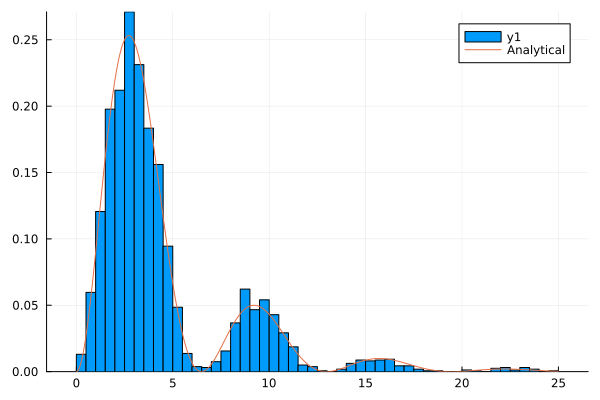

In [14]:
WTD_analytical(tau) =  (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
histogram(tau_sample, normalize=:pdf)
plot!(t_given, Distributions.pdf.(f, t_given), label="Analytical")

In [83]:
r_sample

1000×3×500 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0        -1.0
 0.0  0.0249443  -0.999689
 0.0  0.0497178  -0.998763
 0.0  0.0743067  -0.997235
 0.0  0.098698   -0.995117
 0.0  0.122879   -0.992422
 0.0  0.146839   -0.98916
 0.0  0.170566   -0.985346
 0.0  0.194049   -0.980992
 0.0  0.21728    -0.976109
 0.0  0.240247   -0.970712
 0.0  0.262943   -0.964811
 0.0  0.285359   -0.958421
 ⋮               
 0.0  0.975605    0.219535
 0.0  0.971273    0.237967
 0.0  0.966586    0.256342
 0.0  0.961543    0.274653
 0.0  0.956144    0.292897
 0.0  0.950388    0.311067
 0.0  0.944274    0.32916
 0.0  0.937802    0.34717
 0.0  0.930972    0.365091
 0.0  0.923782    0.382918
 0.0  0.916233    0.400647
 0.0  0.908323    0.41827

[:, :, 2] =
 0.0  0.0        -1.0
 0.0  0.0249443  -0.999689
 0.0  0.0497178  -0.998763
 0.0  0.0743067  -0.997235
 0.0  0.098698   -0.995117
 0.0  0.122879   -0.992422
 0.0  0.146839   -0.98916
 0.0  0.170566   -0.985346
 0.0  0.194049   -0.980992
 0.0  0.21728    -0.9761

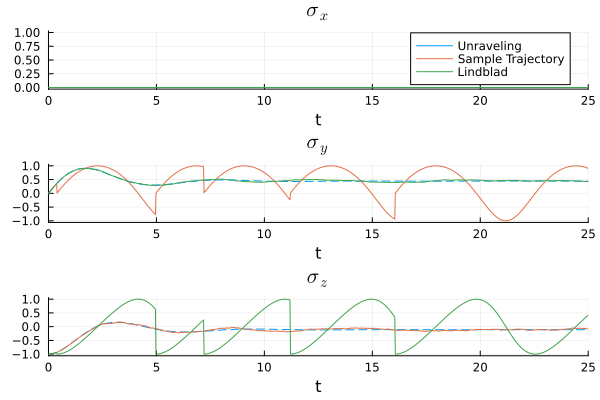

In [93]:
using LaTeXStrings
p1 = plot(t_given, r_avg[:, 1], label="Unraveling", title=L"\sigma_x")
plot!(t_given, r_sample[:,1, 1], label="Sample Trajectory")
plot!(sol, idxs =(0, 1), label="Lindblad ")
p2 = plot(sol, idxs =(0, 2), title=L"\sigma_y", line=:dash, legend=false)
plot!(t_given, r_sample[:,2, 1])
plot!(t_given, r_avg[:, 2])
p3 = plot(sol, idxs = (0,3), title=L"\sigma_z", line=:dash, legend=false)
plot!(t_given, r_avg[:, 3])
plot!(t_given, r_sample[:,3, 1])
plot(p1, p2,p3,  layout=(3, 1))